# Line bands

The second input in a $\mathrm{LiMe}$ measurement is the line bands. These are the intervales with the line location and two adjacent and featureless continua. This design was inspired by the the Lick indexes by [Worthey et al (1993) and references therein](https://ui.adsabs.harvard.edu/abs/1994ApJS...94..687W/abstract). The image below shows an example with the bands for the  $[NeIII]3869Å$  line: 

<img src="../images/bands_definition.png" width="1200" />

A band consists in a 6-value array $(w_{1},.. w_{6})$ with the wavelength boundaries for the line location and two adjacent continua. For $\mathrm{LiMe}$ measurements, it is **essential** that:
   * The wavelenght array is sorted from lower to higher values.
   * The wavelength values are in the rest frame.
   * The wavelength units are the same as those declared in the target $\tt{lime.Spectrum}$ or $\tt{lime.Cube}$ observations.


The central band limits provide the following information: 
   * The location of the line. These are the pixels used to compute the integrated flux and fit the profile.
   * By default $\mathrm{LiMe}$ uses this band limits to compute the linear continuum of the line.  

The adjacent bands must be featureless and located before and after the line region. The provide the following information:
   * If the user observation does not include the flux uncertainty, $\mathrm{LiMe}$ will use these bands to provide a constant pixel uncertainty for each line. 
   * The user can choose that the linear continuum is computed from these bands.

## Bands width determination

As it was presented in the previous tutorial, $\mathrm{LiMe}$ includes a lines database which includes the line labels and bands:

In [1]:
import lime
from pathlib import Path

lines_db = lime.line_bands()

print(lines_db)

                wavelength     wave_vac             w1             w2  \
H1_1215A         1215.1108    1215.6699    1100.000000    1150.000000   
N4_1483A         1483.3300    1483.3300    1450.000000    1460.000000   
N4_1487A         1486.5000    1486.5000    1450.000000    1460.000000   
C4_1548A         1547.6001    1548.1870    1440.000000    1450.000000   
He2_1640A        1639.7896    1640.3913    1600.000000    1630.000000   
...                    ...          ...            ...            ...   
Ne3_155600A    155600.0000  155600.0000  155008.881230  155234.494353   
H2-S1_170300A  170300.0000  170300.0000  170000.000000  170100.000000   
S3_187100A     187100.0000  187100.0000  186289.064584  186679.342348   
Ne5_243200A    243200.0000  243200.0000  242435.988182  242853.181654   
O4_258900A     258900.0000  258900.0000  257943.398290  258470.089756   

                          w3             w4             w5             w6  \
H1_1215A         1195.000000    1230.000000   

By default these values are in Angstroms. 

It is recommended that you adjust the line bands to your observation resolution and wavelength range. $\mathrm{LiMe}$ provides a few tools to do this:  

### Automatic calculation:

$\mathrm{LiMe}$ can adjust the width of the central bands automatically using the $\tt{.line\_bands}$ from a $\tt{lime.Spectrum}$ observation: 

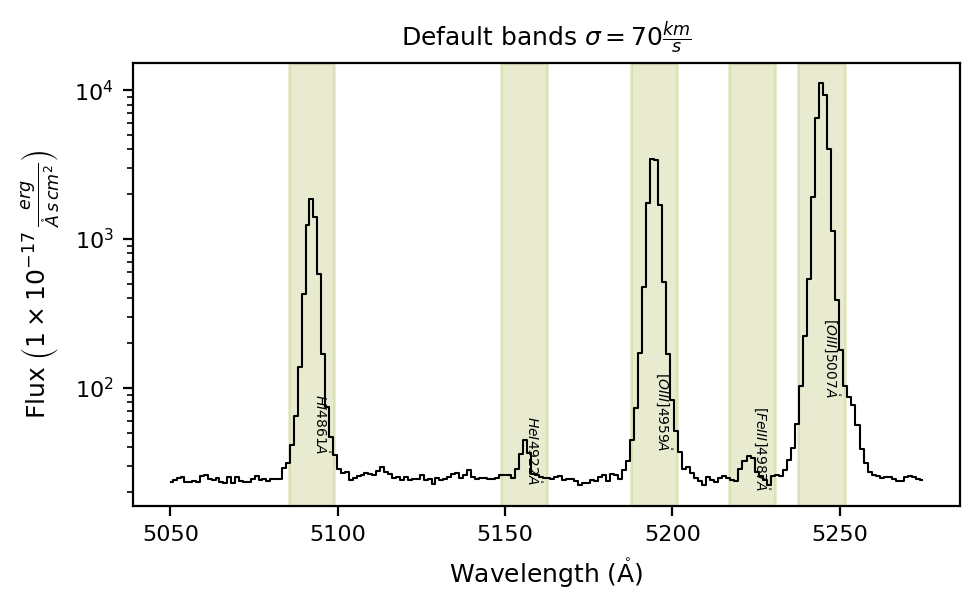

In [26]:
import lime
from pathlib import Path

# Create the observations
data_folder = Path('../sample_data/spectra')
sloan_SHOC579 = data_folder/'sdss_dr18_0358-51818-0504.fits'
spec = lime.Spectrum.from_file(sloan_SHOC579, instrument='sdss', redshift=0.0475, crop_waves=(5050, 5275))

# Adjust the default lines database to the observation wavelength range and resolving power
lines_df = spec.retrieve.line_bands(band_velocity_sigma=70, n_sigma=4, instrumental_correction=True, adjust_central_bands=True)

# Plot the bands over the observation
spec.plot.spectrum(bands=lines_df, log_scale=True, ax_cfg={'title': r'Default bands $\sigma=70\frac{km}{s}$'})

In this case, we are using the default parameter values for the $\tt{band\_velocity\_sigma=70}$, $\tt{n\_sigma=4}$ and $\tt{instrumental\_correction=True}$. This central band width calculation follows these steps:
 * Convert the theoretical transition wavelength to the observed frame using the input redshift.
 * Convert the $\tt{band\_velocity\_sigma}$ from $km/s$ to the observation wavelength units assuming $\mathrm{\frac{c}{\sigma}=\frac{\lambda}{\Delta \lambda}=R}$
 * If requested, use the instrument resolving power to **add** the instrument broadening to the central bands. This is useful for instruments with not constant resolving power in surveys with multi-redshift objects. 
 * Multiply the lines sigma times the number of sigmas ($\tt{n\_sigmas}$) to compute the $\mathrm{w3}$, $\mathrm{w4}$ limits.

In the example above we can appreciate that the bands are a bit narrow because the emission lines display a wide components. You can adjust these bands by increasing the  $\tt{band\_velocity\_sigma}$:

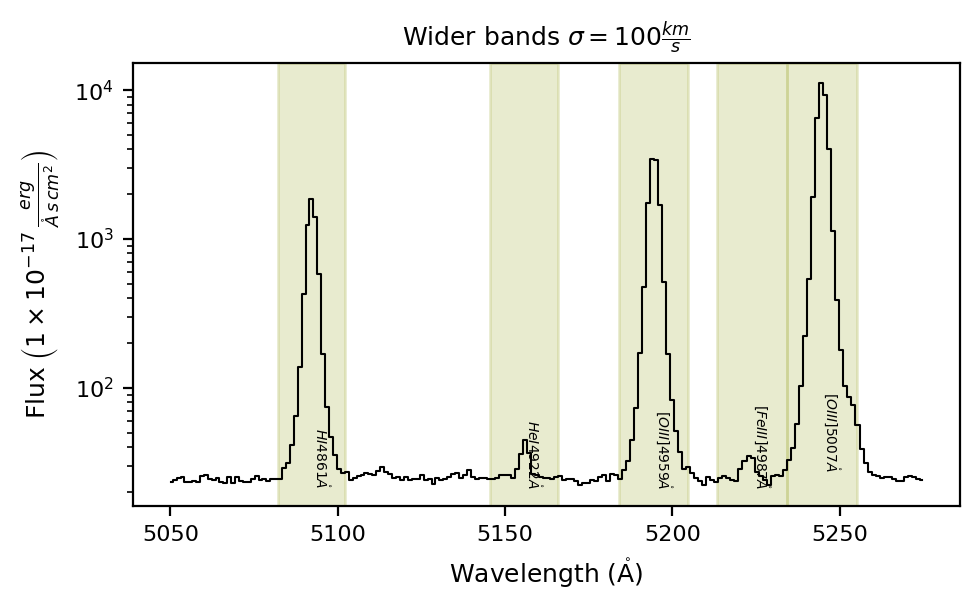

In [32]:
# Adjust the default lines database to the observation wavelength range and resolving power
lines_df = spec.retrieve.line_bands(band_velocity_sigma=120, n_sigma=4, instrumental_correction=True, adjust_central_bands=True)

# Plot the bands over the observation
spec.plot.spectrum(bands=lines_df, log_scale=True, ax_cfg={'title': r'Wider bands $\sigma=100\frac{km}{s}$'})

If you want to fit the lines at a constant velocity you can disable the addition of the instrumental correction: 

Bands sigma velocity times n_sigmas
H1_4861A     560.0
He1_4922A    560.0
O3_4959A     560.0
Fe3_4987A    560.0
O3_5007A     560.0
dtype: float64


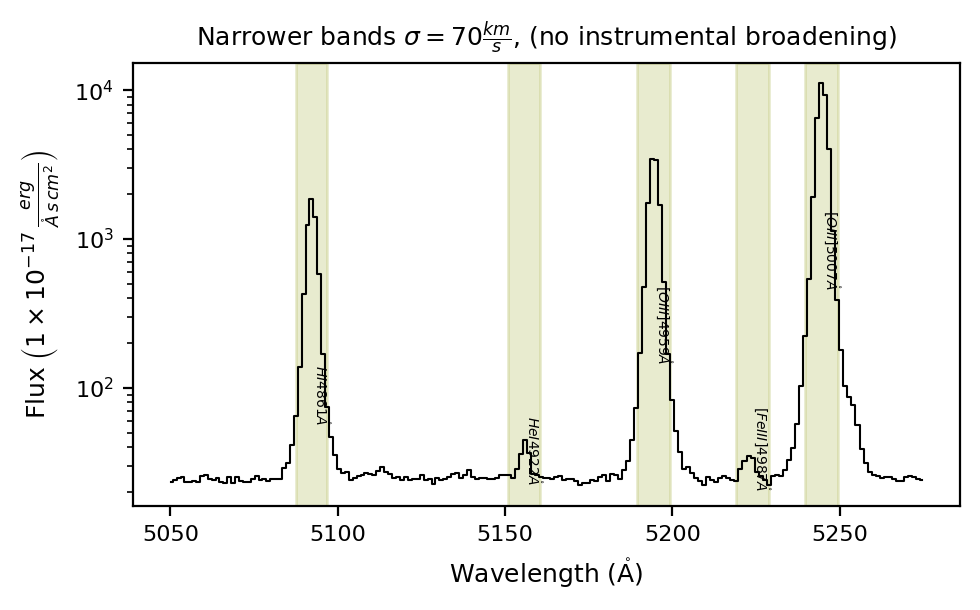

In [34]:
# Import lime light velocity
from lime.fitting.lines import c_KMpS

# Adjust the default lines database to the observation wavelength range
lines_df = spec.retrieve.line_bands(band_velocity_sigma=70, n_sigma=4, instrumental_correction=False, adjust_central_bands=True)

# Velocity bands velocity in Km/s
print('Bands sigma velocity times n_sigmas')
print(c_KMpS * (lines_df['w4'] - lines_df['w3'])/lines_df['wavelength'])

# Plot the bands over the observation
spec.plot.spectrum(bands=lines_df, log_scale=True, ax_cfg={'title': r'Narrower bands $\sigma=70\frac{km}{s}$, (no instrumental broadening)'})

### Manual selection:

The automatic adjustment might not be enough to cover blended lines or avoid bad pixels on the observations. In this case you can manually adjust the line selection using the $\texttt{spec.check.bands}$:

/home/vital/anaconda3/envs/Lime2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


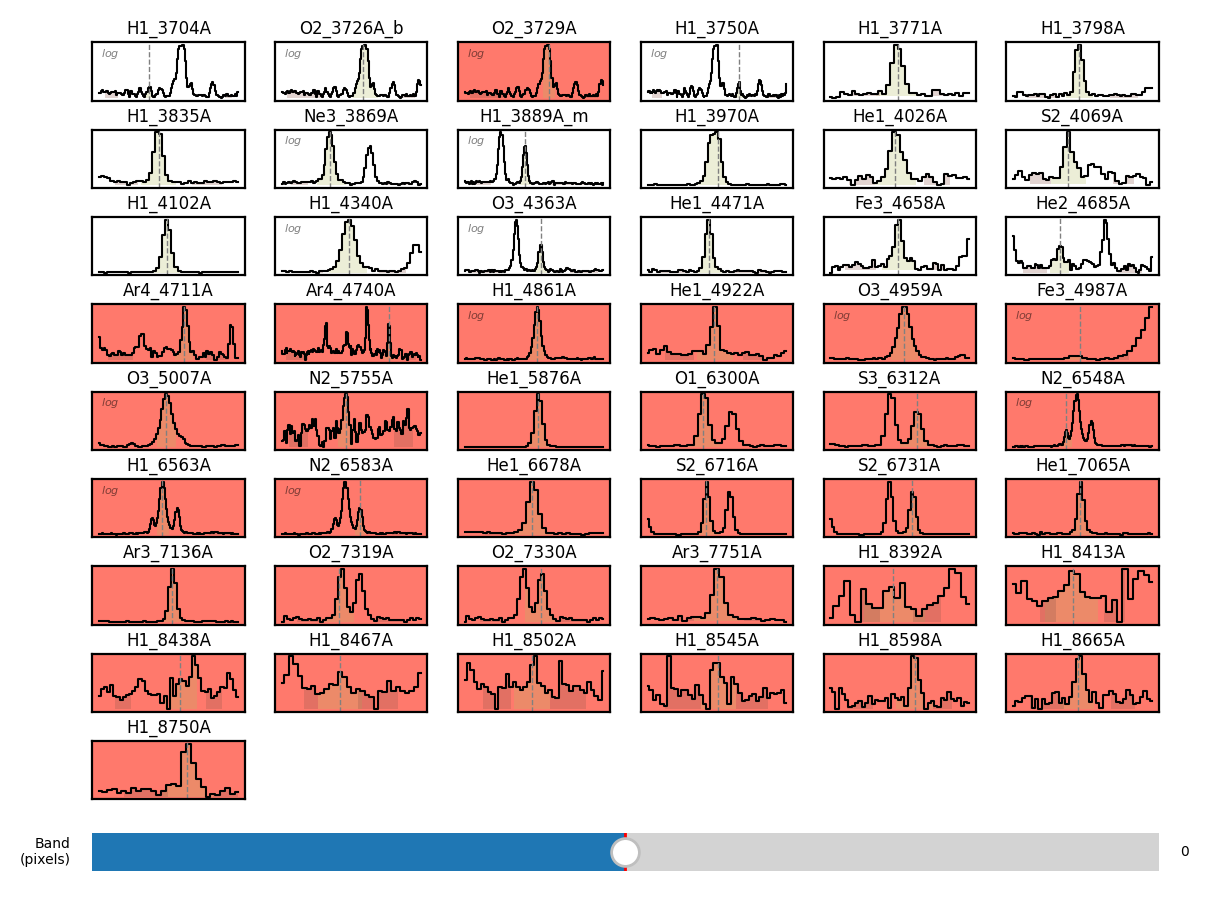

In [38]:
# Create the observation
data_folder = Path('../sample_data')
sloan_SHOC579 = data_folder/'spectra'/'sdss_dr18_0358-51818-0504.fits'
bands_df_file = data_folder/'SHOC579_bands.txt'
spec = lime.Spectrum.from_file(sloan_SHOC579, instrument='sdss', redshift=0.0475)

# Adjust the default lines database to the observation wavelength range
lines_df = spec.retrieve.line_bands(band_velocity_sigma=70, n_sigma=4, instrumental_correction=True)

# Manual adjustment of bands, we use the new bands as reference instead of the default database
spec.check.bands(bands_df_file, ref_bands=lines_df)

You can use the mouse to interact with this plot:
* Right-click on a line sub-plot will include/exclude the line from the output bands file (the excluded lines have a red background).
* Middle-click on a line plot will change the line label suffix on the output bands file. The options are blended **(_b)**, merged **(_m)** and single **(no suffix)** lines. This will change line label the plot title correspondingly.
* Left-click and drag allows you to change the bands limits.

In the lattest case, the line or continua bands selections depends on the initical click point. There are some caveats in the window selection:
* The plot wavelength range is always 5 pixels beyond the bands limits. Therefore dragging the mouse beyond the initial bands limits (below $w1$ or above $w6$) will change the displayed range. This can be used to move beyond the original wavelength limits.
* Selections between the $w2$ and $w5$ wavelengths are always assigned to the line region bands as the new $w3$ and $w4$ values.
* Due to the previous point, to increase/decrease the the $w2$ or $w5$ positions, the user must select a region between $w1$ and $w3$ or $w4$ and $w6$ respectively.

Each of these adjustments is stored in the input ``bands_file``.

Finally, if you observations include the flux uncertainty and the line continuum level can be adjusted better with the $w3$ and $w4$ values, you can limit the selection to the central bands by setting ``exclude_continua=True``: 

/home/vital/anaconda3/envs/Lime2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


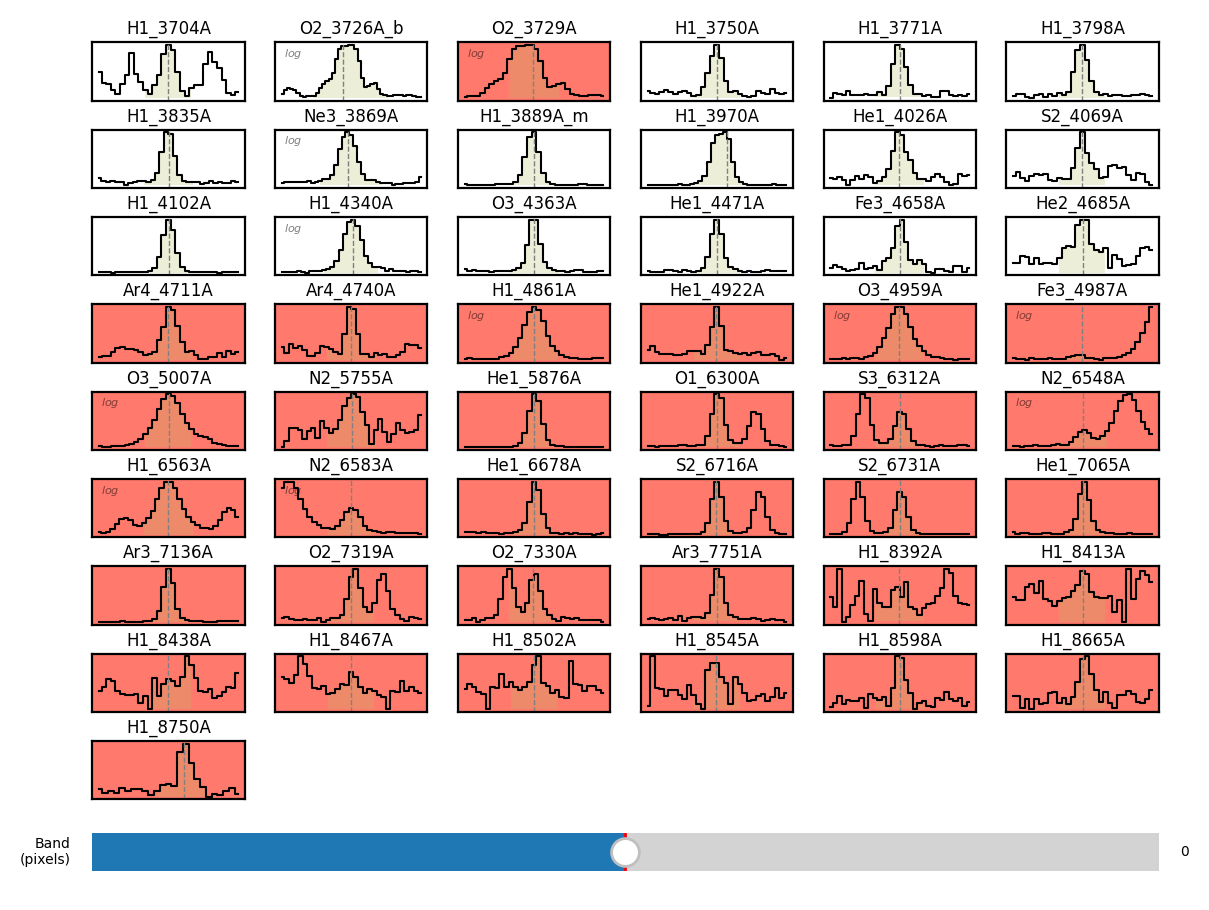

In [39]:
# Manual adjustment of just the central bands
spec.check.bands(bands_df_file, ref_bands=lines_df, exclude_continua=True)

The mouse commands are the same as before but the selection dragging only affects the $w3$ and $w4$ limits.

## Takeaways

* You should always adjust the line bands prior to your measurements to get an idea of the lines you are expecting and the wavelength range you cover.
* Line includes a database which can be adjusted to your observation using: $\tt{lime.Spectrum.line\_bands}$ function. This will adjust the line list to the observation units and the wavelength range.
* You can adjust the central bands width to a certain velocity and include the instrumental broadening.
* You can make final interactive adjustments with the $\tt{lime.Spectrum.check.bands}$